In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

In [2]:
# Read and format data
path = 'data/combined_data_new.csv'

df_all = pd.read_csv(path)
df_all = df_all.loc[df_all.Temperature.notna()]

df_all.date_time_current = pd.to_datetime(df_all.date_time_current, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_future = pd.to_datetime(df_all.date_time_future, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_current_rounded = pd.to_datetime(df_all.date_time_current_rounded, format = "%Y-%m-%d %H:%M:%S")

df_all["forecast_interval"] = df_all.date_time_future - df_all.date_time_current_rounded
df_all["forecast_error"] = df_all.total_demand - df_all.forecast_demand
df_all["forecast_error_relative"] = df_all.forecast_error/df_all.total_demand

df_all["date_time_future_hour"] = df_all.date_time_future.dt.hour

In [3]:
period_id = 24
arima_order = (6,0,2)
arima_season_order = (1, 0, 1, 7)

train_test_split = 0.7

### SARIMA - Without Exogenous Variables

In [4]:
df_predict = pd.DataFrame(columns = ["period_id", "date_time_future", "new_forecast", "forecast_demand", "total_demand"])

for hour_of_day in set(df_all.date_time_future_hour):
    df_delta = df_all.loc[(df_all.period_id == period_id) & (df_all.date_time_future_hour == hour_of_day) & (df_all.date_time_future.dt.minute == 0)].sort_values("date_time_future").reset_index(drop = True)

    # Test/Train split
    split_int = int(train_test_split * len(df_delta))
    df_delta_train, df_delta_test = df_delta[:split_int], df_delta[split_int:]
    x_all, x_train, x_test = df_delta.forecast_error, df_delta_train.forecast_error, df_delta_test.forecast_error

    # Model - Train Data
    arima_model_train = ARIMA(x_train, order = arima_order, seasonal_order = arima_season_order)
    arima_mode_train_fit = arima_model_train.fit()

    # Model - Test Data
    arima_model_test = ARIMA(x_all, order = arima_order, seasonal_order = arima_season_order)
    arima_model_test_fit = arima_model_test.filter(arima_mode_train_fit.params) # Assigns parameter values from train

    # Predicted Values
    arima_model_test_predict = arima_model_test_fit.predict().loc[split_int:]

    # Calculate new forecast
    df_delta_test["predicted_forecast_error"] = arima_model_test_predict
    df_delta_test["new_forecast"] = df_delta_test.forecast_demand + df_delta_test.predicted_forecast_error

    # Model evaluation
    mse_pre = mean_squared_error(df_delta_test.total_demand,df_delta_test.forecast_demand)
    mse_post = mean_squared_error(df_delta_test.total_demand,df_delta_test.new_forecast)
    mape_pre = mean_absolute_percentage_error(df_delta_test.total_demand,df_delta_test.forecast_demand)
    mape_post = mean_absolute_percentage_error(df_delta_test.total_demand,df_delta_test.new_forecast)

    df_predict = pd.concat([df_predict, df_delta_test[["period_id", "date_time_future", "new_forecast", "forecast_demand", "total_demand"]]])

### SARIMA - With Exogenous Variables
- Temperature (forecasted)
- Humidity (forecasted)
- Wind_speed (forecasted)
- Rain (forecasted)

In [5]:
df_predict_with_exog = pd.DataFrame(columns = ["period_id", "date_time_future", "new_forecast", "forecast_demand", "total_demand"])
exog_vars = ["Temperature", "Humidity", "Wind_speed", "Rain"]

for hour_of_day in set(df_all.date_time_future_hour):
    df_delta = df_all.loc[(df_all.period_id == period_id) & (df_all.date_time_future_hour == hour_of_day) & (df_all.date_time_future.dt.minute == 0)].sort_values("date_time_future").reset_index(drop = True)

    # Test/Train split
    split_int = int(train_test_split * len(df_delta))
    df_delta_train, df_delta_test = df_delta[:split_int], df_delta[split_int:]
    x_all, x_train, x_test = df_delta.forecast_error, df_delta_train.forecast_error, df_delta_test.forecast_error
    exog_all, exog_train, exog_test = df_delta[exog_vars], df_delta_train[exog_vars], df_delta_test[exog_vars]

    # Model - Train Data
    arima_model_train = ARIMA(x_train, exog = exog_train, order = arima_order, seasonal_order = arima_season_order)
    arima_mode_train_fit = arima_model_train.fit()

    # Model - Test Data
    arima_model_test = ARIMA(x_all, exog = exog_all, order = arima_order, seasonal_order = arima_season_order)
    arima_model_test_fit = arima_model_test.filter(arima_mode_train_fit.params) # Assigns parameter values from train

    # Predicted Values
    arima_model_test_predict = arima_model_test_fit.predict().loc[split_int:]

    # Calculate new forecast
    df_delta_test["predicted_forecast_error"] = arima_model_test_predict
    df_delta_test["new_forecast"] = df_delta_test.forecast_demand + df_delta_test.predicted_forecast_error

    # Model evaluation
    mse_pre = mean_squared_error(df_delta_test.total_demand,df_delta_test.forecast_demand)
    mse_post = mean_squared_error(df_delta_test.total_demand,df_delta_test.new_forecast)
    mape_pre = mean_absolute_percentage_error(df_delta_test.total_demand,df_delta_test.forecast_demand)
    mape_post = mean_absolute_percentage_error(df_delta_test.total_demand,df_delta_test.new_forecast)

    df_predict_with_exog = pd.concat([df_predict_with_exog, df_delta_test[["period_id", "date_time_future", "new_forecast", "forecast_demand", "total_demand"]]])

### Model Evaluation

In [10]:
df_predict["forecast_error_old"] = df_predict.total_demand - df_predict.forecast_demand
df_predict["forecast_error_new"] = df_predict.total_demand - df_predict.new_forecast
df_predict_with_exog["forecast_error_new"] = df_predict_with_exog.total_demand - df_predict_with_exog.new_forecast

mse_pre = mean_squared_error(df_predict.total_demand, df_predict.forecast_demand)
mse_sarima = mean_squared_error(df_predict.total_demand, df_predict.new_forecast)
mse_sarima_with_exog = mean_squared_error(df_predict_with_exog.total_demand, df_predict_with_exog.new_forecast)

mape_pre = mean_absolute_percentage_error(df_predict.total_demand, df_predict.forecast_demand)
mape_sarima = mean_absolute_percentage_error(df_predict.total_demand, df_predict.new_forecast)
mape_sarima_with_exog = mean_absolute_percentage_error(df_predict_with_exog.total_demand, df_predict_with_exog.new_forecast)

print(f'MSE Old = {mse_pre}, MSE SARIMA (no Exog) = {mse_sarima}, MSE SARIMA (with Exog) = {mse_sarima_with_exog}')
print(f'MAPE Old = {round(100*mape_pre,3)}%, MAPE SARIMA (no Exog) = {round(100*mape_sarima,3)}%, MAPE SARIMA (with Exog) = {round(100*mape_sarima_with_exog,3)}%')

MSE Old = 55078.33198205807, MSE SARIMA (no Exog) = 49519.31974525575, MSE SARIMA (with Exog) = 49165.3293292465
MAPE Old = 2.178%, MAPE SARIMA (no Exog) = 2.049%, MAPE SARIMA (with Exog) = 2.082%


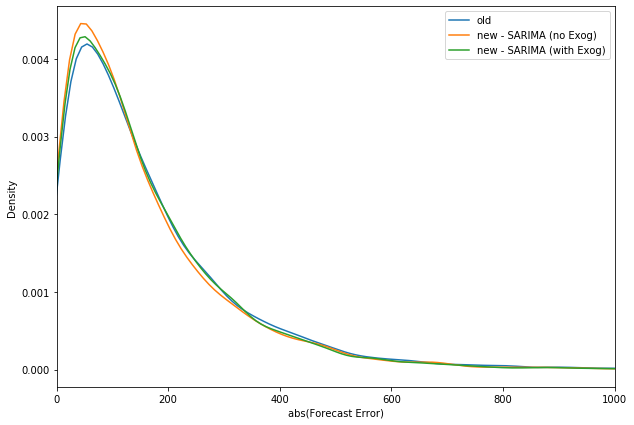

In [11]:
plt.subplots(figsize = (10,7))
sns.kdeplot(abs(df_predict.forecast_error_old), label = 'old')
sns.kdeplot(abs(df_predict.forecast_error_new), label = 'new - SARIMA (no Exog)')
sns.kdeplot(abs(df_predict_with_exog.forecast_error_new), label = 'new - SARIMA (with Exog)')
plt.xlabel('abs(Forecast Error)')
plt.legend()
plt.xlim(0, 1000);

Text(0.5, 1.0, 'Sample Forecast (no Exog)')

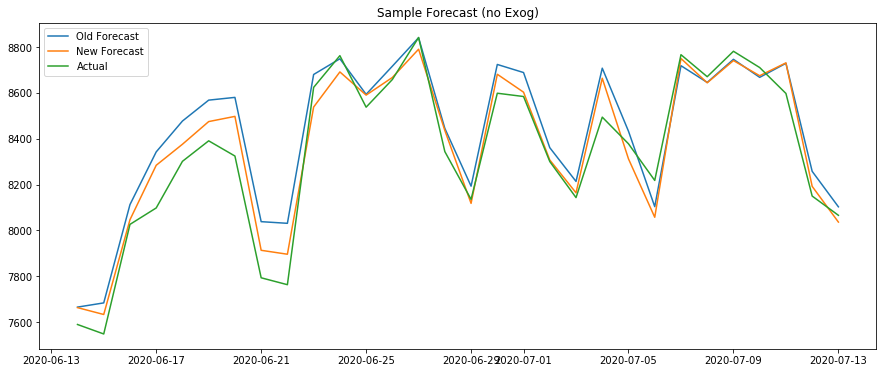

In [12]:
plt.subplots(figsize = (15, 6))
df_plot = df_predict.iloc[100:130]
plt.plot(df_plot.date_time_future, df_plot.forecast_demand, label = 'Old Forecast')
plt.plot(df_plot.date_time_future, df_plot.new_forecast, label = 'New Forecast')
plt.plot(df_plot.date_time_future, df_plot.total_demand, label = 'Actual')
plt.legend()
plt.title('Sample Forecast (no Exog)')

In [17]:
df_predict[["date_time_future", "total_demand", "forecast_demand", "new_forecast"]].rename({"new_forecast": "sarima_prediction"}, axis = 1).to_csv("data/results_SARIMA.csv")